In [1]:
import sys
sys.path.insert(0, "../src")

import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

import sys
if '..' not in sys.path:
    sys.path.append('..')
    
from probabilistic_model import ProbabilisticModel

In [2]:
def frame_to_pressure_comp(idx, write_freq):
    '''
        Calculates the pressure associated with the provided
        frame assuming the same compression rates across all
        simulations. 
    '''
    timestep = idx * write_freq
    ns = timestep / 2000000
    pressure = ns * 3000
    return pressure

def frame_to_pressure_decomp(idx, write_freq):
    '''
        Calculates the pressure associated with the provided
        frame assuming the same compression rates across all
        simulations. 
    '''
    timestep = idx * write_freq
    ns = timestep / 2000000
    pressure = ns * 3000
    return 36001. - pressure

def load_composition_data(model='mbpol', temp=80, type='comp'):
    '''
        Computes means and errors in HDA/LDA compositions for the specified water
        model, temperature, and simulation type across three replicates.
    '''
    data_1 = np.load(f'../data/labels/model_{model}_size_16_feat_5_include_0.999/{type}_{temp}_1.frac.npy')
    data_2 = np.load(f'../data/labels/model_{model}_size_16_feat_5_include_0.999/{type}_{temp}_2.frac.npy')
    data_3 = np.load(f'../data/labels/model_{model}_size_16_feat_5_include_0.999/{type}_{temp}_3.frac.npy')
    min_length = np.min([data_1.shape[0], data_2.shape[0], data_3.shape[0]])
    data_all = np.stack([data_1[0:min_length], data_2[0:min_length], data_3[0:min_length]], axis=0)
    data = np.mean(data_all, axis=0)
    data_err = np.std(data_all, axis=0) / np.sqrt(3.0)
    other_1 = 1.0 - data_1[:,0] - data_1[:,1]
    other_2 = 1.0 - data_2[:,0] - data_2[:,1]
    other_3 = 1.0 - data_3[:,0] - data_3[:,1]
    other_all = np.stack([other_1[0:min_length], other_2[0:min_length], other_3[0:min_length]], axis=0)
    other = np.mean(other_all, axis=0)
    other_err = np.std(other_all, axis=0) / np.sqrt(3.0)
    data = np.hstack((data, other.reshape(-1,1)))
    data_err = np.hstack((data_err, other_err.reshape(-1,1)))
    return data, data_err

## SCAN

In [3]:
data_file_path1 = '../data/thermo/DP_SCAN_Small_3000barns_compression_densityvpressure_data.npz'
data1 = np.load(data_file_path1, allow_pickle=True)

data_file_path2 = '../data/thermo/DP_SCAN_Small_3000barns_decompression_densityvpressure_data.npz'
data2 = np.load(data_file_path2, allow_pickle=True)

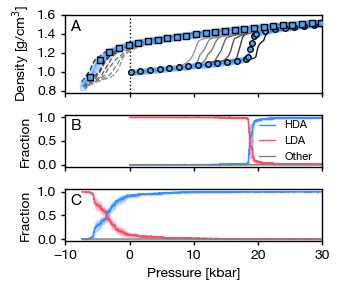

In [4]:
# Combined 3-panel plot with shared x-axis
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.0
fig, axs = plt.subplots(3, 1, figsize=(3.5, 3), sharex=True, sharey=False,  gridspec_kw={'height_ratios': [1.5, 1, 1]})

# ==================== PANEL 1: Density plot ====================
TEMP_COLORS = {
    200: '#67001f',  # Dark red
    180: '#b2182b',  # Red
    160: '#d6604d',  # Light red
    140: '#f4a582',  # Pale red
    120: '#92c5de',  # Light blue
    100: '#4393c3',  # Medium blue
    # 80: '#2166ac',   # Dark blue
    80: '#4DA5FE',
    60: '#053061'    # Very dark blue
}

custom_opaque_ranges = {200: {'Compression': (26, 35), 'Decompression': (119, 119)},
                        180: {'Compression': (33, 40), 'Decompression': (119, 119)},
                        160: {'Compression': (36, 44), 'Decompression': (119, 119)},
                        140: {'Compression': (41, 49), 'Decompression': (119, 119)},
                        120: {'Compression': (46, 54), 'Decompression': (119, 119)},
                        100: {'Compression': (51, 59), 'Decompression': (119, 119)},
                         80: {'Compression': (61, 65), 'Decompression': (120, 119)},
                         60: {'Compression': (66, 71), 'Decompression': (119, 119)}}

temps_data1 = sorted(set([int(key.split('K')[0].split('_')[-1]) for key in data1.keys() if 'barostat_pressure' in key]))
temps_data2 = sorted(set([int(key.split('K')[0]) for key in data2.keys()]))
temps = sorted(set(temps_data1 + temps_data2))

min_temp = min(temps)
max_temp = max(temps)

def get_color_and_zorder(temp, temps_list):
    if temp == 80:
        return TEMP_COLORS[temp], 10  
    else:
        normalized = (temp - min_temp) / (max_temp - min_temp)
        gray_value = 0.1 + normalized * 0.5  
        return str(gray_value), 1

for temp in temps:          
    # Compression from data1
    comp_pressure_key = f"DP_SCAN_{temp}K_Compression_barostat_pressure"
    comp_density_key = f"DP_SCAN_{temp}K_Compression_density_avg"
    
    if comp_pressure_key in data1.keys():
        color, zorder = get_color_and_zorder(temp, temps)
        barostat_pressure = data1[comp_pressure_key] / 1000
        density_avg = data1[comp_density_key]
        
        axs[0].plot(barostat_pressure, density_avg, color=color, label=f'{temp}K Compression', linestyle='-', linewidth=1.0, zorder=zorder)
        
        if temp == 80:
            custom_range = custom_opaque_ranges.get(temp, {}).get('Compression', (0, 0))
            
            for i, (x, y) in enumerate(zip(barostat_pressure, density_avg)):
                if i % 5 == 0 or custom_range[0] <= i <= custom_range[1]:
                    axs[0].plot(x, y, marker='o', color=color, markersize=4, alpha=1, 
                           markeredgewidth=1, markeredgecolor='black', zorder=10)
                else:
                    axs[0].plot(x, y, marker='o', color=color, markersize=4, alpha=0.3, zorder=1)
    
    # Decompression from data2 
    decomp_key = f"{temp}K_Decompression"
    if decomp_key in data2.keys():
        color, zorder = get_color_and_zorder(temp, temps)
        plot_data = data2[decomp_key].item()
        barostat_pressure = np.array(plot_data['barostat_pressure']) / 1000 
        density_avg = plot_data['density_avg']
        
        axs[0].plot(barostat_pressure, density_avg, color=color, label=f'{temp}K Decompression', linestyle='--', linewidth=1.0, zorder=zorder)
        
        if temp == 80:
            custom_range = custom_opaque_ranges.get(temp, {}).get('Decompression', (0, 0))
            
            for i, (x, y) in enumerate(zip(barostat_pressure, density_avg)):
                if i % 5 == 0 or custom_range[0] <= i <= custom_range[1]:
                    axs[0].plot(x, y, marker='s', color=color, markersize=4, alpha=1, 
                           markeredgewidth=1, markeredgecolor='black', zorder=10)
                else:
                    axs[0].plot(x, y, marker='s', color=color, markersize=4, alpha=0.3, zorder=1)

for spine in axs[0].spines.values():
    spine.set_linewidth(1.0)
    spine.set_color('black')

axs[0].set_ylabel('Density [g/cm$^3$]')
axs[0].set_ylim(0.78, 1.6)
axs[0].set_yticks([0.8, 1, 1.2, 1.4, 1.6])
axs[0].tick_params(width=1.0, length=3.0, direction='out')
axs[0].axvline(x=0, color='black', linestyle='dotted', linewidth=1)
axs[0].text(0.02, 0.93, 'A', transform=axs[0].transAxes, fontsize=11, va='top', ha='left', weight='bold')

# ==================== PANEL 2: Compression data ====================
data_comp, data_err_comp = load_composition_data(model='scan', temp=80, type='comp')
frames_comp = np.array([i + 1 for i in range(data_comp.shape[0])])
press_comp = frame_to_pressure_comp(frames_comp, write_freq=5000)
press_comp /= 1000  

axs[1].plot(press_comp, data_comp[:,0], label='HDA', color='#398EFF', linewidth=1.0)
axs[1].plot(press_comp, data_comp[:,1], label='LDA', color='#FA516B', linewidth=1.0)
axs[1].plot(press_comp, data_comp[:,2], label='Other', color='gray', linewidth=1.0)
axs[1].fill_between(press_comp, data_comp[:,0] + data_err_comp[:,0], data_comp[:,0] - data_err_comp[:,0], color='#398EFF', alpha=0.3)
axs[1].fill_between(press_comp, data_comp[:,1] + data_err_comp[:,1], data_comp[:,1] - data_err_comp[:,1], color='#FA516B', alpha=0.3)
axs[1].fill_between(press_comp, data_comp[:,2] + data_err_comp[:,2], data_comp[:,2] - data_err_comp[:,2], color='gray', alpha=0.3)

for spine in axs[1].spines.values():
    spine.set_linewidth(1.0)
    spine.set_color('black')

axs[1].set_ylabel('Fraction')
axs[1].set_yticks(ticks=[0.0, 0.5, 1.0])
axs[1].tick_params(axis='both', left=True, bottom=True, width=1.0, length=3.0, direction='out')
axs[1].text(0.02, 0.93, 'B', transform=axs[1].transAxes, fontsize=11, va='top', ha='left', weight='bold')
axs[1].legend(frameon=False, loc='center right', handlelength=1.5, fontsize=8)

# ==================== PANEL 3: Decompression data ====================
data_decomp, data_err_decomp = load_composition_data(model='scan', temp=80, type='decomp')
frames_decomp = np.array([i + 1 for i in range(data_decomp.shape[0])])
press_decomp = frame_to_pressure_decomp(frames_decomp, write_freq=10000)
press_decomp /= 1000  

axs[2].plot(press_decomp, data_decomp[:,0], label='HDA', color='#398EFF', linewidth=1.0)
axs[2].plot(press_decomp, data_decomp[:,1], label='LDA', color='#FA516B', linewidth=1.0)
axs[2].plot(press_decomp, data_decomp[:,2], label='Other', color='gray', linewidth=1.0)
axs[2].fill_between(press_decomp, data_decomp[:,0] + data_err_decomp[:,0], data_decomp[:,0] - data_err_decomp[:,0], color='#398EFF', alpha=0.3)
axs[2].fill_between(press_decomp, data_decomp[:,1] + data_err_decomp[:,1], data_decomp[:,1] - data_err_decomp[:,1], color='#FA516B', alpha=0.3)
axs[2].fill_between(press_decomp, data_decomp[:,2] + data_err_decomp[:,2], data_decomp[:,2] - data_err_decomp[:,2], color='gray', alpha=0.3)

for spine in axs[2].spines.values():
    spine.set_linewidth(1.0)
    spine.set_color('black')

axs[2].set_ylabel('Fraction')
axs[2].set_xlabel('Pressure [kbar]')
axs[2].set_yticks(ticks=[0.0, 0.5, 1.0])
axs[2].tick_params(axis='both', left=True, bottom=True, width=1.0, length=3.0, direction='out')
axs[2].text(0.02, 0.90, 'C', transform=axs[2].transAxes, fontsize=11, va='top', ha='left', weight='bold')

# ==================== Shared x-axis settings ====================
axs[2].set_xlim(-10, 30)
axs[2].set_xticks([-10, 0, 10, 20, 30])

plt.tight_layout()
plt.savefig('./figures/scan_transitionwiththermo.svg', dpi=1000)
plt.show()

## MBpol

In [5]:
data_file_path1 = '../data/thermo/DP_MBpol_Small_3000barns_compression_densityvpressure_data.npz'
data1 = np.load(data_file_path1, allow_pickle=True)

data_file_path2 = '../data/thermo/DP_MBpol_Small_3000barns_decompression_densityvpressure_data.npz'
data2 = np.load(data_file_path2, allow_pickle=True)

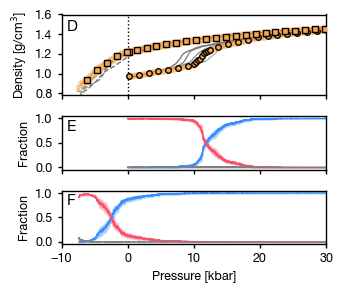

In [6]:
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 9
plt.rcParams['axes.linewidth'] = 1.0
fig, axs = plt.subplots(3, 1, figsize=(3.5, 3), sharex=True, sharey=False,  gridspec_kw={'height_ratios': [1.5, 1, 1]})

# ==================== PANEL 1: Density plot ====================
TEMP_COLORS = {
    200: '#67001f',  # Dark red
    180: '#b2182b',  # Red
    160: '#d6604d',  # Light red
    140: '#f4a582',  # Pale red
    120: '#92c5de',  # Light blue
    100: '#4393c3',  # Medium blue
    # 80: '#2166ac',   # Dark blue
    80: "#F9A54B",
    60: '#053061'    # Very dark blue
}

custom_opaque_ranges = {200: {'Compression': (21, 28), 'Decompression': (119, 119)},
                        180: {'Compression': (87, 89), 'Decompression': (119, 119)},
                        160: {'Compression': (91, 93), 'Decompression': (119, 119)},
                        140: {'Compression': (22, 29), 'Decompression': (119, 119)},
                        120: {'Compression': (26, 32), 'Decompression': (119, 119)},
                        100: {'Compression': (31, 37), 'Decompression': (119, 119)},
                         80: {'Compression': (33, 41), 'Decompression': (119, 119)},
                         60: {'Compression': (36, 44), 'Decompression': (119, 119)}}

temps = sorted(set([int(key.split('K')[0]) for key in data1.keys()] + [int(key.split('K')[0]) for key in data2.keys()]))

# Create grayscale gradient mapping
min_temp = min(temps)
max_temp = max(temps)

def get_color_and_zorder(temp, temps_list):
    """Get color and zorder for a given temperature"""
    if temp == 80:
        return TEMP_COLORS[temp], 10  # High zorder to be on top
    else:
        # Map temperature to grayscale: lightest for lowest temp, darkest for highest
        normalized = (temp - min_temp) / (max_temp - min_temp)
        gray_value = 0.7 - (normalized * 0.4)  # 0.7 (light) to 0.3 (dark)
        return str(gray_value), 1  # Low zorder to be underneath

for temp in temps:
    comp_key = f"{temp}K_Compression"
    if comp_key in data1.keys():
        color, zorder = get_color_and_zorder(temp, temps)
        
        plot_data = data1[comp_key].item()
        barostat_pressure = np.array(plot_data['barostat_pressure']) / 1000
        density_avg = plot_data['density_avg']
        
        axs[0].plot(barostat_pressure, density_avg, color=color, label=f'{temp}K Compression', 
                linestyle='-', linewidth=1.0, zorder=zorder)
        
        # Only plot markers for 80K
        if temp == 80:
            custom_range = custom_opaque_ranges.get(temp, {}).get('Compression', (0, 0))
            
            for i, (x, y) in enumerate(zip(barostat_pressure, density_avg)):
                if i % 5 == 0 or custom_range[0] <= i <= custom_range[1]:
                    axs[0].plot(x, y, marker='o', color=color, markersize=4, alpha=1, 
                           markeredgewidth=1, markeredgecolor='black', zorder=10)
                else:
                    axs[0].plot(x, y, marker='o', color=color, markersize=4, alpha=0.3, zorder=1)
    
    # Only plot decompression up to 140K
    if temp <= 140:
        decomp_key = f"{temp}K_Decompression"
        if decomp_key in data2.keys():
            color, zorder = get_color_and_zorder(temp, temps)
            
            plot_data = data2[decomp_key].item()
            barostat_pressure = np.array(plot_data['barostat_pressure']) / 1000
            density_avg = plot_data['density_avg']
            
            axs[0].plot(barostat_pressure, density_avg, color=color, label=f'{temp}K Decompression', 
                    linestyle='--', linewidth=1.0, zorder=zorder)
            
            # Only plot markers for 80K
            if temp == 80:
                custom_range = custom_opaque_ranges.get(temp, {}).get('Decompression', (0, 0))
                
                for i, (x, y) in enumerate(zip(barostat_pressure, density_avg)):
                    if i % 5 == 0 or custom_range[0] <= i <= custom_range[1]:
                        axs[0].plot(x, y, marker='s', color=color, markersize=4, alpha=1, 
                               markeredgewidth=1, markeredgecolor='black', zorder=10)
                    else:
                        axs[0].plot(x, y, marker='s', color=color, markersize=4, alpha=0.3, zorder=1)

for spine in axs[0].spines.values():
    spine.set_linewidth(1.0)
    spine.set_color('black')

axs[0].set_ylabel('Density [g/cm$^3$]')
axs[0].set_ylim(0.78, 1.6)
axs[0].set_yticks([0.8, 1, 1.2, 1.4, 1.6])
axs[0].tick_params(width=1.0, length=3, direction='out')
axs[0].axvline(x=0, color='black', linestyle='dotted', linewidth=1)
axs[0].text(0.02, 0.93, 'D', transform=axs[0].transAxes, fontsize=11, va='top', ha='left', weight='bold')

# ==================== PANEL 2: Compression data ====================
TEMP = 80
data_comp, data_err_comp = load_composition_data(model='mbpol', temp=TEMP, type='comp')
frames_comp = np.array([i + 1 for i in range(data_comp.shape[0])])
press_comp = frame_to_pressure_comp(frames_comp, write_freq=5000)
press_comp /= 1000  

axs[1].plot(press_comp, data_comp[:,0], label='HDA', color='#398EFF', linewidth=1.0)
axs[1].plot(press_comp, data_comp[:,1], label='LDA', color='#FA516B', linewidth=1.0)
axs[1].plot(press_comp, data_comp[:,2], label='Other', color='gray', linewidth=1.0)
axs[1].fill_between(press_comp, data_comp[:,0] + data_err_comp[:,0], data_comp[:,0] - data_err_comp[:,0], color='#398EFF', alpha=0.3)
axs[1].fill_between(press_comp, data_comp[:,1] + data_err_comp[:,1], data_comp[:,1] - data_err_comp[:,1], color='#FA516B', alpha=0.3)
axs[1].fill_between(press_comp, data_comp[:,2] + data_err_comp[:,2], data_comp[:,2] - data_err_comp[:,2], color='gray', alpha=0.3)

for spine in axs[1].spines.values():
    spine.set_linewidth(1.0)
    spine.set_color('black')

axs[1].set_ylabel('Fraction')
axs[1].set_yticks(ticks=[0.0, 0.5, 1.0])
axs[1].tick_params(axis='both', left=True, bottom=True, width=1.0, length=3, direction='out')
axs[1].text(0.02, 0.93, 'E', transform=axs[1].transAxes, fontsize=11, va='top', ha='left', weight='bold')
# axs[1].legend(frameon=False, loc='center right', handlelength=1.5, fontsize=8)

# ==================== PANEL 3: Decompression data ====================
data_decomp, data_err_decomp = load_composition_data(model='mbpol', temp=TEMP, type='decomp')
frames_decomp = np.array([i + 1 for i in range(data_decomp.shape[0])])
press_decomp = frame_to_pressure_decomp(frames_decomp, write_freq=10000)
press_decomp /= 1000  

axs[2].plot(press_decomp, data_decomp[:,0], label='HDA', color='#398EFF', linewidth=1.0)
axs[2].plot(press_decomp, data_decomp[:,1], label='LDA', color='#FA516B', linewidth=1.0)
axs[2].plot(press_decomp, data_decomp[:,2], label='Other', color='gray', linewidth=1.0)
axs[2].fill_between(press_decomp, data_decomp[:,0] + data_err_decomp[:,0], data_decomp[:,0] - data_err_decomp[:,0], color='#398EFF', alpha=0.3)
axs[2].fill_between(press_decomp, data_decomp[:,1] + data_err_decomp[:,1], data_decomp[:,1] - data_err_decomp[:,1], color='#FA516B', alpha=0.3)
axs[2].fill_between(press_decomp, data_decomp[:,2] + data_err_decomp[:,2], data_decomp[:,2] - data_err_decomp[:,2], color='gray', alpha=0.3)

for spine in axs[2].spines.values():
    spine.set_linewidth(1.0)
    spine.set_color('black')

axs[2].set_ylabel('Fraction')
axs[2].set_xlabel('Pressure [kbar]')
axs[2].set_yticks(ticks=[0.0, 0.5, 1.0])
axs[2].tick_params(axis='both', left=True, bottom=True, width=1.0, length=3, direction='out')
axs[2].text(0.02, 0.93, 'F', transform=axs[2].transAxes, fontsize=11, va='top', ha='left', weight='bold')

# ==================== Shared x-axis settings ====================
axs[2].set_xlim(-10, 30)
axs[2].set_xticks([-10, 0, 10, 20, 30])

plt.tight_layout()
plt.savefig('./figures/mbpol_transitionwiththermo.svg', dpi=1000)
plt.show()

In [7]:
# Gather data for non-equilibrium phase diagram.
true_data_scan_comp = {
    60: [20433.00, 447.60],
    80: [18758.00, 150.60],
    100: [17134.50, 219.56],
    120: [15922.00, 104.23],
    140: [14232.00, 317.15],
    160: [12649.00, 305.82],
    180: [11513.00, 320.32],
    200: [10075.00, 138.35]
}
true_data_mbpol_comp = {
    60: [13228.00, 192.74],
    80: [10983.00, 211.66],
    100: [10379.00, 410.68],
    120: [8789.00, 161.57],
    140: [8190.00, 75.31],
}

# Write down exceptional rates.
rates = {
    'comp_140_2.frac.npy': 10000,
    'comp_160_3.frac.npy': 10000,
    'comp_180_1.frac.npy': 10000,
    'comp_200_1.frac.npy': 10000,
    'comp_200_3.frac.npy': 10000
}

SIZE = 16

# Compute transition temperatures/pressures for compression data.
scan_compression_data = {}
for filename in os.listdir(f'../data/labels/model_scan_size_{SIZE}_feat_5_include_0.999/'):
    if 'decomp' not in filename and '.frac.' in filename:
        data = np.load(f'../data/labels/model_scan_size_{SIZE}_feat_5_include_0.999/{filename}')
        temp = int(filename.split('_')[1])
        candidate_idx = np.argwhere(data[:,0] > data[:,1]).reshape(-1)
        transition_frame = candidate_idx[0].item()
        write_freq = rates[filename] if filename in rates.keys() else 5000
        pressure = frame_to_pressure_comp(transition_frame, write_freq)
        if temp not in scan_compression_data.keys():
            scan_compression_data[temp] = []
        scan_compression_data[temp].append(pressure)

for key, value in scan_compression_data.items():
    scan_compression_data[key] = [np.mean(value), np.std(value) / np.sqrt(len(value))]

mbpol_compression_data = {}
for filename in os.listdir(f'../data/labels/model_mbpol_size_{SIZE}_feat_5_include_0.999/'):
    if 'decomp' not in filename and '.frac.' in filename:
        data = np.load(f'../data/labels/model_mbpol_size_{SIZE}_feat_5_include_0.999/{filename}')
        temp = int(filename.split('_')[1])
        candidate_idx = np.argwhere(data[:,0] > data[:,1]).reshape(-1)
        transition_frame = candidate_idx[0].item()
        write_freq = 5000
        pressure = frame_to_pressure_comp(transition_frame, write_freq)
        if temp not in mbpol_compression_data.keys():
            mbpol_compression_data[temp] = []
        mbpol_compression_data[temp].append(pressure)
for key, value in mbpol_compression_data.items():
    mbpol_compression_data[key] = [np.mean(value), np.std(value) / np.sqrt(len(value))]

# Compute transition temperatures/pressure for decompression data.
scan_decompression_data = {}
for filename in os.listdir(f'../data/labels/model_scan_size_{SIZE}_feat_5_include_0.999/'):
    if 'decomp' in filename and '.frac.' in filename:
        data = np.load(f'../data/labels/model_scan_size_{SIZE}_feat_5_include_0.999/{filename}')
        temp = int(filename.split('_')[1])
        candidate_idx = np.argwhere(data[:,0] < data[:,1]).reshape(-1)
        transition_frame = candidate_idx[0].item()
        write_freq = 10000
        pressure = frame_to_pressure_decomp(transition_frame, write_freq)
        if temp not in scan_decompression_data.keys():
            scan_decompression_data[temp] = []
        scan_decompression_data[temp].append(pressure)
for key, value in scan_decompression_data.items():
    scan_decompression_data[key] = [np.mean(value), np.std(value) / np.sqrt(len(value))]

mbpol_decompression_data = {}
for filename in os.listdir(f'../data/labels/model_mbpol_size_{SIZE}_feat_5_include_0.999/'):
    if 'decomp' in filename and '.frac.' in filename:
        data = np.load(f'../data/labels/model_mbpol_size_{SIZE}_feat_5_include_0.999/{filename}')
        temp = int(filename.split('_')[1])
        candidate_idx = np.argwhere(data[:,0] < data[:,1]).reshape(-1)
        transition_frame = candidate_idx[0].item()
        write_freq = 10000
        pressure = frame_to_pressure_decomp(transition_frame, write_freq)
        if temp not in mbpol_decompression_data.keys():
            mbpol_decompression_data[temp] = []
        mbpol_decompression_data[temp].append(pressure)
for key, value in mbpol_decompression_data.items():
    mbpol_decompression_data[key] = [np.mean(value), np.std(value) / np.sqrt(len(value))]

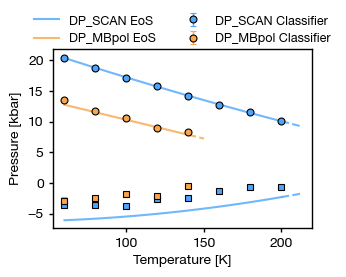

In [8]:
fit_data_scan = np.load('../data/thermo/scan_thermospinodal.npz')
fit_data_mbpol = np.load('../data/thermo/mbpol_thermospinodal.npz')

# Construct non-equilibrium phase diagram
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.0

fig, ax = plt.subplots(1,1,figsize=(3.5, 3.0))

scan_color = "#4DA5FE"
mbpol_color = "#F9A54B"

# Plot SCAN spinodal lines from Thermo EoS
ax.plot(fit_data_scan['ldatohda_temp_fit'], fit_data_scan['ldatohda_press_fit'] / 1000, 
        color=scan_color, linewidth=1.5, linestyle='-', alpha=0.8)
ax.plot(fit_data_scan['ldatohda_temp_extrap'], fit_data_scan['ldatohda_press_extrap'] / 1000, 
        color=scan_color, linewidth=1.5, linestyle='--', alpha=0.8)
ax.plot(fit_data_scan['hdatolda_temp_fit'], fit_data_scan['hdatolda_press_fit'] / 1000, 
        color=scan_color, linewidth=1.5, linestyle='-', alpha=0.8, label='DP_SCAN EoS')
ax.plot(fit_data_scan['hdatolda_temp_extrap'], fit_data_scan['hdatolda_press_extrap'] / 1000, 
        color=scan_color, linewidth=1.5, linestyle='--', alpha=0.8)

# Plot MBpol spinodal lines from Thermo EoS
ax.plot(fit_data_mbpol['ldatohda_temp_fit'], fit_data_mbpol['ldatohda_press_fit'] / 1000, 
        color=mbpol_color, linewidth=1.5, linestyle='-', alpha=0.8, label='DP_MBpol EoS')
ax.plot(fit_data_mbpol['ldatohda_temp_extrap'], fit_data_mbpol['ldatohda_press_extrap'] / 1000, 
        color=mbpol_color, linewidth=1.5, linestyle='--', alpha=0.8)

# Plot SCAN classifier results
ax.errorbar(
    [key for key in scan_compression_data.keys()], 
    [val[0] / 1000 for val in scan_compression_data.values()], 
    yerr=[val[1] / 1000 for val in scan_compression_data.values()],
    color=scan_color,
    mec='black', markeredgewidth=0.8, ms=5,
    fmt='o', capsize=2, capthick=1, elinewidth=1, 
    label='DP_SCAN Classifier',
)
ax.errorbar(
    [key for key in scan_decompression_data.keys()], 
    [val[0] / 1000 for val in scan_decompression_data.values()], 
    yerr=[val[1] / 1000 for val in scan_decompression_data.values()],
    color=scan_color,
    mec='black', markeredgewidth=0.8, ms=5,
    fmt='s', capsize=2, capthick=1, elinewidth=1,
)
# Plot MBpol classifier results 
ax.errorbar(
    [key for key in mbpol_compression_data.keys()], 
    [val[0] / 1000 for val in mbpol_compression_data.values()], 
    yerr=[val[1] / 1000 for val in mbpol_compression_data.values()],
    color=mbpol_color,
    mec='black', markeredgewidth=0.8, ms=5,
    fmt='o', capsize=2, capthick=1, elinewidth=1, 
    label='DP_MBpol Classifier',
)
ax.errorbar(
    [key for key in mbpol_decompression_data.keys()], 
    [val[0] / 1000 for val in mbpol_decompression_data.values()], 
    yerr=[val[1] / 1000 for val in mbpol_decompression_data.values()],
    color=mbpol_color,
    mec='black', markeredgewidth=0.8, ms=5,
    fmt='s', capsize=2, capthick=1, elinewidth=1,
)
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Pressure [kbar]')
ax.tick_params(axis='both', left=True, bottom=True, width=1.0, length=3.0, direction='out')
legend = ax.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.25), frameon=False, fontsize=9)

plt.tight_layout()
plt.savefig('./figures/transition_diagram.pdf', dpi=1000, bbox_inches='tight')

In [9]:
def get_feature_names():
    '''Method for generating feature names for ACSFs and Steinhardt parameters.'''
    from dscribe.descriptors import ACSF
    from steinhardt import desc_to_index_mapping
    feature_names = []
    acsf = ACSF(
        species=['H', 'O'],
        periodic=False,
        r_cut=5.0,
        g2_params=[[0.5, 1.0],[1.0, 1.0],[1.5, 1.0],[2.0, 1.0],[2.5, 1.0],[3.0, 1.0],[3.5, 1.0],[4.0, 1.0],[4.5, 1.0],[5.0, 1.0]],
        g3_params=[0.5, 1.0, 1.5, 2.0],
        g4_params=[[0.0, 1.0, 1.0],[0.0, 0.5, 1.0],[2.0, 1.0, 1.0],[2.0, 0.5, 1.0],[4.5, 1.0, 1.0],[4.5, 0.5, 1.0],[0.0, 1.0, -1.0],[0.0, 0.5, -1.0],[2.0, 1.0, -1.0],[2.0, 0.5, -1.0],[4.5, 1.0, -1.0],[4.5, 0.5, -1.0]],
        g5_params=[[2.0, 1.0, 1.0],[2.0, 0.5, 1.0],[4.5, 1.0, 1.0],[4.5, 0.5, 1.0],[2.0, 1.0, -1.0],[2.0, 0.5, -1.0],[4.5, 1.0, -1.0],[4.5, 0.5, -1.0]]
    )
    for spec in ['H', 'O']:
        feature_names.append(f'G1 | {spec}')
        for param_set in acsf.g2_params:
                feature_names.append(f'G2 | {spec} | {param_set}')
        for param_set in acsf.g3_params:
            feature_names.append(f'G3 | {spec} | {param_set}')
    for spec in ['H-H', 'H-O', 'O-O']:
        for param_set in acsf.g4_params:
            feature_names.append(f'G4 | {spec} | {param_set}')
        for param_set in acsf.g5_params:
            feature_names.append(f'G5 | {spec} | {param_set}')
    for key in desc_to_index_mapping.keys():
        feature_names.append(key)
    return feature_names

In [10]:
feature_names = get_feature_names()
for i, feat in enumerate(feature_names):
    print(i, feat)

0 G1 | H
1 G2 | H | [0.5, 1.0]
2 G2 | H | [1.0, 1.0]
3 G2 | H | [1.5, 1.0]
4 G2 | H | [2.0, 1.0]
5 G2 | H | [2.5, 1.0]
6 G2 | H | [3.0, 1.0]
7 G2 | H | [3.5, 1.0]
8 G2 | H | [4.0, 1.0]
9 G2 | H | [4.5, 1.0]
10 G2 | H | [5.0, 1.0]
11 G3 | H | 0.5
12 G3 | H | 1.0
13 G3 | H | 1.5
14 G3 | H | 2.0
15 G1 | O
16 G2 | O | [0.5, 1.0]
17 G2 | O | [1.0, 1.0]
18 G2 | O | [1.5, 1.0]
19 G2 | O | [2.0, 1.0]
20 G2 | O | [2.5, 1.0]
21 G2 | O | [3.0, 1.0]
22 G2 | O | [3.5, 1.0]
23 G2 | O | [4.0, 1.0]
24 G2 | O | [4.5, 1.0]
25 G2 | O | [5.0, 1.0]
26 G3 | O | 0.5
27 G3 | O | 1.0
28 G3 | O | 1.5
29 G3 | O | 2.0
30 G4 | H-H | [0.0, 1.0, 1.0]
31 G4 | H-H | [0.0, 0.5, 1.0]
32 G4 | H-H | [2.0, 1.0, 1.0]
33 G4 | H-H | [2.0, 0.5, 1.0]
34 G4 | H-H | [4.5, 1.0, 1.0]
35 G4 | H-H | [4.5, 0.5, 1.0]
36 G4 | H-H | [0.0, 1.0, -1.0]
37 G4 | H-H | [0.0, 0.5, -1.0]
38 G4 | H-H | [2.0, 1.0, -1.0]
39 G4 | H-H | [2.0, 0.5, -1.0]
40 G4 | H-H | [4.5, 1.0, -1.0]
41 G4 | H-H | [4.5, 0.5, -1.0]
42 G5 | H-H | [2.0, 1.0, 1.0]
43 G5 

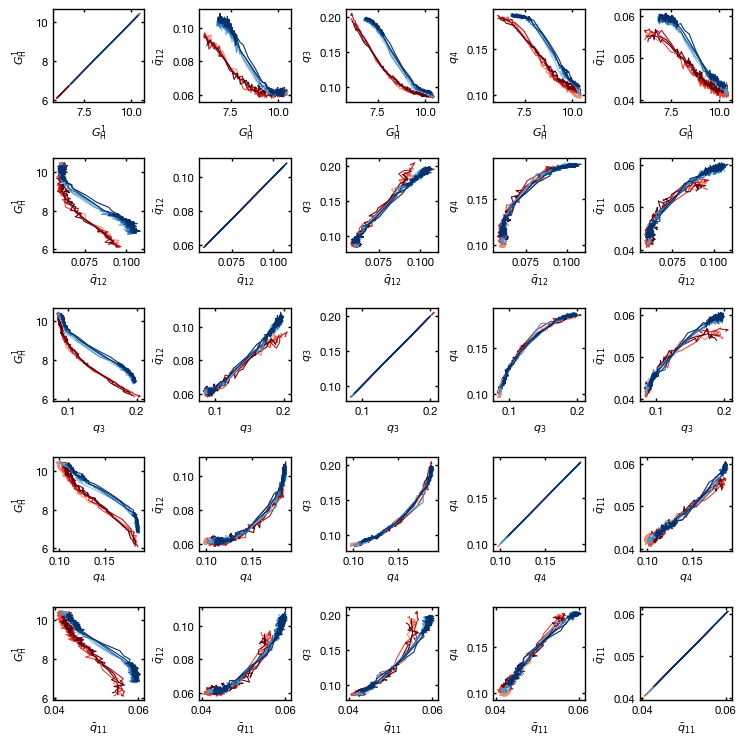

In [51]:
# Analyze descriptor trajectories for pairs of first five descriptors.
MODEL = 'scan'

# Analysis inputs.
trajectories = [
    f'model_{MODEL}_size_16_feat_5_include_0.999/comp_60_1.feat.npy',
    f'model_{MODEL}_size_16_feat_5_include_0.999/comp_80_1.feat.npy',
    f'model_{MODEL}_size_16_feat_5_include_0.999/comp_100_1.feat.npy',
    f'model_{MODEL}_size_16_feat_5_include_0.999/comp_120_1.feat.npy',
    f'model_{MODEL}_size_16_feat_5_include_0.999/comp_140_1.feat.npy',
    f'model_{MODEL}_size_16_feat_5_include_0.999/decomp_60_1.feat.npy',
    f'model_{MODEL}_size_16_feat_5_include_0.999/decomp_80_1.feat.npy',
    f'model_{MODEL}_size_16_feat_5_include_0.999/decomp_100_1.feat.npy',
    f'model_{MODEL}_size_16_feat_5_include_0.999/decomp_120_1.feat.npy',
    f'model_{MODEL}_size_16_feat_5_include_0.999/decomp_140_1.feat.npy',
]

# Determine features to include.
feat_idx = [0, 1, 2, 3, 4]

# Load models and get relevant features.
selected_feat_3 = [13, 12, 1, 70, 57, 0]
selected_feat_16 = [0, 109, 90, 91, 108]
selected_feat = [29, 100, 1, 13, 109]

selected_feat = selected_feat_16

def get_labels(f1, f2):
    label_dict = {
        0: r'$G_\text{H}^1$',
        109:  r'$\bar{q}_{12}$',
        90: r'$q_3$',
        91: r'$q_4$',
        108: r'$\bar{q}_{11}$',
    }
    return label_dict[f1], label_dict[f2]

# Prepare figure.
#plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['font.size'] = 8
fig, axs = plt.subplots(len(feat_idx),len(feat_idx),figsize=(7.5,7.5))

# Plot each trajectory on each subplot.
comp_map = plt.get_cmap('Blues')
decomp_map = plt.get_cmap('Reds')
comp_colors = [comp_map(0.2 * (p + 1)) for p in range(5,0,-1)]
decomp_colors = [decomp_map(0.2 * (p + 1)) for p in range(5,0,-1)]
colors = [*comp_colors, *decomp_colors]
for traj_idx, traj_file in enumerate(trajectories):
    data = np.load(f'./data/{traj_file}')
    data = data[::20]
    data = np.mean(data, axis=1)
    for f1 in feat_idx:
        for f2 in feat_idx:
            FEATS = [selected_feat[f1], selected_feat[f2]]
            data_ = data[:,[FEATS[0], FEATS[1]]]
            axs[f1,f2].plot(data_[:,0], data_[:,1], color=colors[traj_idx], linewidth=0.8, zorder=len(trajectories) - traj_idx)
            x_label, y_label = get_labels(selected_feat[f1], selected_feat[f2])
            axs[f1,f2].set_xlabel(x_label)
            axs[f1,f2].set_ylabel(y_label)
            axs[f1,f2].tick_params(axis='both', left=True, right=True, top=True, bottom=True, width=1.0, length=2.0, direction='in')

# Final figure preparations.
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace=0.6)
plt.savefig('./figures/transition_features_grid_scan.pdf', dpi=500)
plt.show()

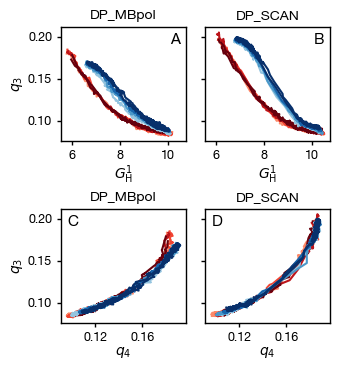

In [36]:
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Helvetica Neue'

fig, axs = plt.subplots(2, 2, figsize=(3.5, 3.8), sharey='row', sharex='row')

# descriptor_pairs = [
#     {
#         'feat_idx': [0,109],
#         'xlabel': r'$G_{\text{H}}^{1}$',
#         'ylabel': r'$\bar{q}_{12}$',
#         'labels': ['A', 'B']
#     },
#     {
#         'feat_idx': [29,109],
#         'xlabel': r'$G_{\text{O}}^{3}(\kappa=2.0)$',
#         'ylabel': r'$\bar{q}_{12}$',
#         'labels': ['C', 'D']
#     }
# ]

descriptor_pairs = [
    {
        'feat_idx': [0,90],
        'xlabel': r'$G_{\text{H}}^{1}$',
        'ylabel': r'$q_{3}$',
        'labels': ['A', 'B']
    },
    {
        'feat_idx': [91,90],
        'xlabel': r'$q_{4}$',
        'ylabel': r'$q_{3}$',
        'labels': ['C', 'D']
    }
]

for row_idx, desc_pair in enumerate(descriptor_pairs):
    for m_idx, MODEL in enumerate(['mbpol', 'scan']):

        trajectories = [
            f'model_{MODEL}_size_16_feat_5_include_0.999/comp_60_1.feat.npy',
            f'model_{MODEL}_size_16_feat_5_include_0.999/comp_80_1.feat.npy',
            f'model_{MODEL}_size_16_feat_5_include_0.999/comp_100_1.feat.npy',
            f'model_{MODEL}_size_16_feat_5_include_0.999/comp_120_1.feat.npy',
            f'model_{MODEL}_size_16_feat_5_include_0.999/comp_140_1.feat.npy',
            f'model_{MODEL}_size_16_feat_5_include_0.999/decomp_60_1.feat.npy',
            f'model_{MODEL}_size_16_feat_5_include_0.999/decomp_80_1.feat.npy',
            f'model_{MODEL}_size_16_feat_5_include_0.999/decomp_100_1.feat.npy',
            f'model_{MODEL}_size_16_feat_5_include_0.999/decomp_120_1.feat.npy',
            f'model_{MODEL}_size_16_feat_5_include_0.999/decomp_140_1.feat.npy',
        ]
                
        comp_map = plt.get_cmap('Blues')
        decomp_map = plt.get_cmap('Reds')
        comp_colors = [comp_map(0.2 * (p + 1)) for p in range(5, 0, -1)]
        decomp_colors = [decomp_map(0.2 * (p + 1)) for p in range(5, 0, -1)]
        colors = [*comp_colors, *decomp_colors]
        
        ax = axs[row_idx, m_idx]
        
        for traj_idx, traj_file in enumerate(trajectories):
            data = np.load(f'./data/{traj_file}')
            data = data[::10]
            data = np.mean(data, axis=1)
            data_ = data[:, [desc_pair['feat_idx'][0], desc_pair['feat_idx'][1]]]
            ax.plot(data_[:, 0], data_[:, 1], color=colors[traj_idx], zorder=len(trajectories) - traj_idx)
        
        ax.set_xlabel(desc_pair['xlabel'], fontsize=10, labelpad=1.0)
        if m_idx == 0:
            ax.set_ylabel(desc_pair['ylabel'], fontsize=10, labelpad=2.0)
        
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))

        ax.tick_params(axis='both', left=True, right=False, top=False, bottom=True, 
                      width=1.0, length=3.0, direction='out', labelsize=9)

        if MODEL == 'mbpol':
            ax.set_title('DP_MBpol', fontsize=10)
        else:
            ax.set_title('DP_SCAN', fontsize=10)

        if row_idx == 0:
            ax.text(
                0.95, 0.95,
                desc_pair['labels'][m_idx],
                transform=ax.transAxes,
                fontsize=11, fontweight='bold',
                va='top', ha='right'
            )
        else:
            ax.text(
                0.05, 0.95,
                desc_pair['labels'][m_idx],
                transform=ax.transAxes,
                fontsize=11, fontweight='bold',
                va='top', ha='left'
            )


plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
plt.savefig('./figures/transition_environments_combined.svg', dpi=1000)
plt.show()